In [54]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, AveragePooling2D, Flatten, Reshape
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization

from lrn import LRN # custom LRN implementation in Keras

Sahpe is  (145, 145, 5, 5, 200)
Strieds:  (1, 1, 5, 5, 200)
X shape:  (145, 145, 5, 5, 200)
Y shape:  (145, 145)


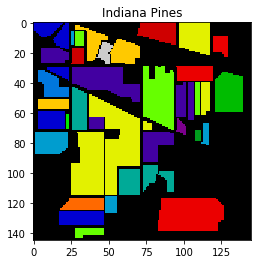

In [2]:
def convertToNeighbours(a, window, step_size):
    shape = a.shape[:-1] + (window, window) + a.shape[-1:]
    print('Sahpe is ', shape)
    #strides = a.strides + (a.strides[-1] * step_size,)
    strides = (1,1,5,5,200)
    print('Strieds: ', strides)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

# plot ground truth as an image
def plotData(gt):
    #plt.plot(gt)
    plt.title('Indiana Pines')
    plt.imshow(gt)
    plt.set_cmap('nipy_spectral')
    
    plt.show()
    
# Load data from .mat files and return test and train split
def loadData(dataSetPath, gtPath):
    dataSet = sio.loadmat(dataSetPath)['indian_pines_corrected']
    #print(dataSet.shape[:-1])
    Y =  sio.loadmat(gtPath)['indian_pines_gt']
    #print(gt.shape)
    X = convertToNeighbours(dataSet, 5, 1)
    print('X shape: ', X.shape)
    print('Y shape: ', Y.shape)
    #print(np.unique(Y))
    plotData(Y)
    
    return X, Y

dataX, dataY = loadData('./dataset.mat', './gt.mat')

In [65]:

dataX = dataX.reshape([-1, 5, 5, 200])
dataY = dataY.reshape([145*145])
print('uniq', np.unique(dataY))
print(dataY)
#dataY = to_categorical(dataY, 17)
# print('New X shape: ', dataX.shape)
# print('New Y shape: ', dataY.shape)

(trainX, testX, trainY, testY) = train_test_split(dataX, dataY, test_size=0.6, random_state=42)

print('Train X and Y: ', trainX.shape, trainY.shape)
print('Test X and Y: ', testX.shape, testY.shape)

augm = ImageDataGenerator(rotation_range=270.0, horizontal_flip=True)
trainGen = augm.flow(trainX, trainY, batch_size=16)
testGen = augm.flow(testX, testY, batch_size=16)

trainSteps = trainX.shape[0] // 16
testSteps = testX.shape[0] // 16
#augm.flow(dataX, dataY)

uniq [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[3 3 3 ..., 0 0 0]
Train X and Y:  (8410, 5, 5, 200) (8410,)
Test X and Y:  (12615, 5, 5, 200) (12615,)


/usr/local/lib/python3.5/dist-packages/keras/preprocessing/image.py:787: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (8410, 5, 5, 200) (200 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')
/usr/local/lib/python3.5/dist-packages/keras/preprocessing/image.py:787: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (12615, 5, 5, 200) (200 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


In [66]:
model = Sequential()
model.add(Conv2D(128, kernel_size=(1, 1), strides=(1,1), padding='same', input_shape=(5, 5, 200), activation='relu'))
model.add(BatchNormalization())
#model.add(LRN(alpha=0.0001, beta=0.75, k=3))
model.add(Dropout(0.6))
model.add(Conv2D(64, kernel_size=(1, 1), strides=(1,1), padding='same', activation='relu'))
model.add(Dropout(0.6))
#model.add(LRN(alpha=0.0001, beta=0.75, n=3))
model.add(BatchNormalization())
model.add(Conv2D(17, kernel_size=(1, 1), strides=(1,1), padding='same', activation='relu'))
#model.add(GlobalAveragePooling2D(data_format='channels_last'))
model.add(AveragePooling2D(strides=(1,1), pool_size=(5,5), data_format='channels_last'))
model.add(Reshape((17, )))
model.summary()
opt = SGD(lr=0.001, decay=1e-6)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 5, 5, 128)         25728     
_________________________________________________________________
batch_normalization_43 (Batc (None, 5, 5, 128)         512       
_________________________________________________________________
dropout_43 (Dropout)         (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 5, 5, 64)          8256      
_________________________________________________________________
dropout_44 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 5, 5, 64)          256       
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 5, 5, 17)          1105      
__________

In [67]:

#model.fit(dataX, dataY, validation_split=0.6, batch_size=16, epochs=100, shuffle=True)
model.fit_generator(generator=trainGen, epochs=100, validation_data=testGen, steps_per_epoch=trainSteps, validation_steps=testSteps)

Epoch 1/100
525/525 [==============================] - 70s - loss: 2.6948 - acc: 0.2130 - val_loss: 3.0433 - val_acc: 0.4124
Epoch 2/100
525/525 [==============================] - 67s - loss: 2.4852 - acc: 0.4514 - val_loss: 2.6812 - val_acc: 0.5098
Epoch 3/100
525/525 [==============================] - 67s - loss: 2.4073 - acc: 0.4965 - val_loss: 2.5801 - val_acc: 0.5113
Epoch 4/100
525/525 [==============================] - 67s - loss: 2.3563 - acc: 0.5072 - val_loss: 2.5391 - val_acc: 0.5112
Epoch 5/100
525/525 [==============================] - 67s - loss: 2.3116 - acc: 0.5061 - val_loss: 2.6376 - val_acc: 0.5125
Epoch 6/100
525/525 [==============================] - 67s - loss: 2.2594 - acc: 0.5084 - val_loss: 2.6765 - val_acc: 0.5124
Epoch 7/100
524/525 [============================>.] - ETA: 0s - loss: 2.2205 - acc: 0.5084

KeyboardInterrupt: 